In [1]:
# %load REINFORCE.py
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import numpy as np
import time 
from IPython.display import clear_output

In [2]:
#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98

# I. Define Policy
## 1.1 init

* Softmax in action preference
* $h(a,s,\theta)$ -- ANN
  * 1 hidden layer, of 128 neurons
  * Activation Func, relu
  * Output layer, Softmax (softmax in action preference!)

# 1.2 train_net, update rules for $\theta$
$$ G \leftarrow \sum^T_{k=t+1} \gamma ^{k-t-1}R_k$$
$$ \theta \leftarrow \theta + \alpha \gamma ^t G \nabla \ln \pi (A_t|S_t, \theta) $$

In [79]:
class Policy(nn.Module):
    def __init__(self, hDim=128):
        super(Policy, self).__init__()
        self.data = []     # data of 1 entire episode
        self.hDim = hDim
        # I. ================================
        # 1.1 Initial Policy network (1)
        self.s2h = nn.Linear(4, self.hDim) # state to hidden
        self.h2o = nn.Linear(self.hDim, 2) # hidden to output 
        self.output = nn.Softmax(dim=1)
        # ===================================

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):

        # I. ================================
        # 1.1 Initial Policy network (2)
        #batch_size = x.size[0] #这里面的0是x大小第1个参数，自动获取batch大小
        h = F.relu(self.s2h(x))
        o1 = self.h2o(h)
        o2 = F.softmax(o1, dim=1)
        # ===================================
        return o2
      
    def put_data(self, item):     # adding data of 1 step
        self.data.append(item)
        
    def train_net(self):
        self.optimizer.zero_grad()
        # III. ==============================
        # 3. Loop for each step of the episode, update theta
        nStep = len(self.data)
        #self.optimizer.zero_grad()
        loss = 0
        for t in range(nStep-1):
            G = 0
            for k in range(t+1, nStep):
                G = G + gamma**(k-t-1) * self.data[k][0] # data (r,prob[a])
            
            # define loss
            loss += -G*torch.log(self.data[t][1])

        # ===================================
        # get gradient
        loss.backward()
        # update step
        self.optimizer.step()
        self.data = []


# II. Sample, Observe carpole
1 episode

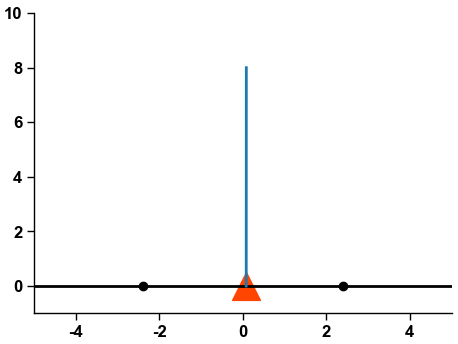

Episode finished after 1 timesteps


In [46]:
s, _ = env.reset()
done = False
t = 0
while not done: # CartPole-v1 forced to terminates at 500 step.
    # 2.0 show
    plt.plot([-5, 5], [0,0], c='black')
    plt.scatter([-2.4, 2.4], [0,0], c='black')
    plt.scatter(s[0], 0, marker='^', c='#FF4500', s = 400)
    plt.plot([s[0], s[0] + 8*np.tan(s[1]*10/180*np.pi)], [0,8])
    plt.xlim(-5,5)
    plt.ylim(-1,10)
    clear_output(True)
    plt.show()
    plt.pause(0.005)

    # II. ===============================
    # 2.1 Sample action, according to pi
    s = torch.tensor(s[np.newaxis,:])    
    a = pi(s)
    m = Categorical(a)
    a = m.sample().item()
    
    # 2.2 observe next step
    s, _, done,_,_ = env.step(a)

    # ===================================
    
    if done:
        print("Episode finished after {} timesteps".format(t+1))

# III. Sample, and train

In [80]:
env = gym.make('CartPole-v1')
pi = Policy()
score = 0.0
print_interval = 20
li_score = []

for n_epi in range(10000):
    s, _ = env.reset()
    done = False
    
    while not done: # CartPole-v1 forced to terminates at 500 step.

        # II. ===============================
        # 2.1 Sample action, according to pi
        s = torch.tensor(s[np.newaxis,:])    
        prob = pi(s) # forward calculation
        m = Categorical(prob) #
        a = m.sample().item() # get action
        

        # 2.2 observe next step,
        # and Record data of 1 step with "pi.put_data", putting (r, prob[a])
        s, r, done,_,_ = env.step(a)
        score += r
        
        pi.put_data((r, prob[0, a]))

        # ===================================
        pass
        
    # 3. Train net
    pi.train_net()
    
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {}".format(n_epi, score/print_interval))
        score = 0.0
    li_score.append(score)
env.close()

# of episode :20, avg score : 25.3
# of episode :40, avg score : 24.65
# of episode :60, avg score : 24.85
# of episode :80, avg score : 26.65
# of episode :100, avg score : 23.9
# of episode :120, avg score : 27.15
# of episode :140, avg score : 26.95
# of episode :160, avg score : 31.65
# of episode :180, avg score : 40.5
# of episode :200, avg score : 23.65
# of episode :220, avg score : 41.95
# of episode :240, avg score : 34.95
# of episode :260, avg score : 41.6
# of episode :280, avg score : 38.05
# of episode :300, avg score : 39.35
# of episode :320, avg score : 39.5
# of episode :340, avg score : 46.65
# of episode :360, avg score : 46.75
# of episode :380, avg score : 40.3
# of episode :400, avg score : 49.5
# of episode :420, avg score : 53.05
# of episode :440, avg score : 43.3
# of episode :460, avg score : 45.85
# of episode :480, avg score : 46.65
# of episode :500, avg score : 44.25
# of episode :520, avg score : 49.25
# of episode :540, avg score : 65.6
# of episode :

In [ ]:
plt.plot(li_score)

In [69]:
torch.autograd.set_detect_anomaly = True